# IN-STK5000: project 1

Christoffer Kleven Berg and Martin Strøm Olsen

# Model development


## Policy

We assume that $A = \{a_{0}, a_{1}\}$, we further define $a_{0}$ as "deny credit" and $a_{1}$ as "offer credit". We also know from the project text that the utility function is assumed to be linear. This implies that among $E(utility|a_{i})$ and $E(utility|a_{j})$, we will always choose action $a_{i}$ over action $a_{j}$ if $E(utility|a_{i}) > E(utility|a_{j})$ adapted from (Dimitrakakis, 2020, p. 48). We will "blindly" choose the action that maximizes expected utility.

## Utility function

There are two possible actions that we could perform: $\{a_{0}, a_{1}\}$. We also have the following rewards, which are defined as possible outcomes for the bank (Dimitrakakis, 2020, p. 47). In our case these rewards are $\{-m, 0, m((1 + r)^{n} - 1)\}$. Further there are two possible actions for the bank when it comes to deciding for each new customer if they will be granted credit.

Further, we will use the definition of expected utility
$$
E[U|a_{t} = a] = \sum_{r} U(r)Pr(r|a_{t} = a)
$$
adapted from (Dimitrakakis, 2020, p. 48). This will be used for each action to calculate its expected utility. We can further define the rewards as $r_{0} =$ "the debtor defaults" and $r_{1} =$ "the debtor does not default". If we use the assumption that the utility function is linear, we can say that $U(r)$ is proportional to $r$.

### Grant credit

If we decide to grant credit ($a_{t} = 1 $) we have the following expected utility considering the rewards above:
$$
E[U|a_{t} = 1] = U(r = r_{0})Pr(r = r_{0}|a_{t} = 1) + U(r = r_{1})Pr(r = r_{1}|a_{t} = 1) 
$$
which becomes
$$
E[U|a_{t} = 1] = -m \cdot Pr(r = r_{0}|a_{t} = 1) + m((1 + r)^{n} - 1) \cdot Pr(r = r_{1}|a_{t} = 1)
$$
In our code, we have defined $Pr(r = r_{1}|a_{t} = 1)$ as the variable "p\_c" and $Pr(r = r_{0}|a_{t} = 1)$ as 1-"p\_c".

### Do not grant credit

If we decide not to grant credit ($a_{t} = 0 $).

$$
E[U|a_{t} = 0] = 0 \cdot Pr(r = r_{0}|a_{t} = 0) + 0 \cdot Pr(r = r_{1}|a_{t} = 0) = 0
$$

In [1]:
def expected_utility(self, X, action):
    """Calculate expected utility using the decision maker model.

    Args:
        X: New observations.
        action: Whether or not to grant the loan.

    Returns:
        The expected utilities of the decision maker.
    """
    if action == 0:
        return np.zeros(X.shape[0])

    r = self.rate
    p_c = self.predict_proba(X)

    # duration in months
    n = X['duration']
    # amount
    m = X['amount']

    e_x = p_c * m * ((1 + r) ** n - 1) + (1 - p_c) * (-m)
    return e_x

## Fitting a model

We chose to use a logistic regression model. It predicts the probability of a binary categorical variable beeing 1. A fresh random state is also given to the model for reproducable results.

In [2]:
def _fit_model(self, X, y):
    """Fits the logistic model.

    Args:
        X: Covariates
        y: Response variable

    Notes:
        Using logistic regression, adapted from
        https://scikit-learn.org/stable/modules/generated/
            sklearn.linear_model.LogisticRegression.html
    """
    log_reg_object = LogisticRegression(random_state=1, max_iter=2000)
    return log_reg_object.fit(X, y)

When reading the data we one hot encode all the catagorical variables which means that they loose the information in the order. This could be fixed by instead giving them an integer value, but then we assume a linear relationship between the order of the categories.

## Best action

The best action is the action that gives the highest utility. In the event of the utilities beeing equal, we chose to not give a loan. Because of the linear utility of the investor it does not matter what we do in this situation, but we figured it is better to not accept unnecessary variability.

In [3]:
def get_best_action(self, X):
    """Gets the best actions defined as the actions that maximizes utility.
    An epsilon for utility is also set as the threshold that the expected
    utility should exceed in order to get the best action. This utility
    epsilon is 0 if the banker is not configured to use this functionality.
    Otherwise it is estimated from the training data as the value that
    provide a type 1 error below the parameter '_max_type1_error'.

    Args:
        X: New observations.

    Returns:
        Best actions based on maximizing utility.
    """
    expected_utility_give_loan = self.expected_utility(X, 1)
    expected_utility_no_loan = self.expected_utility(X, 0)

    give_loan = expected_utility_give_loan > (
        expected_utility_no_loan + self._utility_epsilon)
    return give_loan

def predict_proba(self, X):
    """Predicts the probability for y=1 given new observations.

    Args:
        x: New, independent observations.

    Returns:
        The predicted probabilities for y=1.
    """
    return self.model.predict_proba(X)[:, 1]

# Testing the model against random model

In [31]:
%matplotlib inline

import random_banker
import group1_banker
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import display

## Testing decision makers

In [5]:
def get_raw_data():
    """ Reads in raw data then maps response to 0 and 1 and parses
    the categorical attributes to pandas.caategorical

    Returns:
        pandas DataFrame with the "raw" data
    """
    features = ['checking account balance', 'duration', 'credit history',
                'purpose', 'amount', 'savings', 'employment', 'installment',
                'marital status', 'other debtors', 'residence time',
                'property', 'age', 'other installments', 'housing', 'credits',
                'job', 'persons', 'phone', 'foreign', 'repaid']

    data_raw = pd.read_csv("../../data/credit/german.data",
                           delim_whitespace=True, names=features)

    # Mapping the response to 0 and 1
    data_raw.loc[:, "repaid"] = data_raw["repaid"].map({1: 1, 2: 0})

    categorical_columns = ['checking account balance', 'credit history',
                           'purpose', 'savings', 'employment', 'marital status',
                           'other debtors', 'property', 'other installments',
                           'housing', 'job', 'phone', 'foreign', 'repaid']
    data_raw.loc[:, categorical_columns] = data_raw[categorical_columns].apply(
        lambda x: x.astype('category'))

    return data_raw


def one_hot_encode(data):
    """ One hot encodes specified columns.

    Args:
        data: pandas DataFrame

    Returns:
        Pandas DataFrame with the categorical attributes one hot encoded
    """
    columns = ['checking account balance', 'credit history',
               'purpose', 'savings', 'employment', 'marital status',
               'other debtors', 'property', 'other installments',
               'housing', 'job', 'phone', 'foreign']
    dummies = pd.get_dummies(data[columns], drop_first=True)
    data = data.drop(columns, axis=1)

    return data.join(dummies)


def get_data():
    """ Gets the data and applies one hot encoding

    Returns:
        Pandas DataFrame with the usable data
    """
    data = get_raw_data()
    data = one_hot_encode(data)

    return data

In [6]:
def utility_from_obs(predicted_decision, true_decision, amount, duration, interest_rate):
    """Calculates utility for predicted decisions

    Args:
        predicted_decision: the model's best actions
        true_decision: if the observations repaid or not
        amount: the lending amounts
        duration: the number of periods
        interest_rate: the interest rate of the loan

    Returns:
        numpy array with the utilities for each decision.
    """
    utility = np.zeros_like(true_decision)

    predicted_decision_bool = predicted_decision == 1
    ind1 = np.logical_and(predicted_decision_bool, true_decision == 1)
    ind2 = np.logical_and(predicted_decision_bool, true_decision == 0)

    utility[ind1] = amount[ind1]*((1 + interest_rate)**duration[ind1] - 1)
    utility[ind2] = -amount[ind2]

    return utility


def utility_from_test_set(X, y, decision_maker, interest_rate):
    """Calculates total utility from a given test set.

    Args:
        X: the covariates of the test set
        y: the response variable of the test set
        decision_maker: the decision maker to use in order to calculate utility
        interest_rate: the interest rate to use when calculating utility

    Returns:
        The sum of utility from the test set and the sum of utility divided by
        total amount.
    """
    predicted_decision = decision_maker.get_best_action(X)

    amount = X['amount']
    duration = X['duration']

    utility = utility_from_obs(
        predicted_decision, y, amount, duration, interest_rate)

    return np.sum(utility), np.sum(utility)/np.sum(amount)

In [7]:
def repeated_cross_validation_utility(X, y, bankers, interest_rate, n_repeats=20, n_folds=5):
    """ Preforms repeated cross validation to find estimates for average utility
    for different bankers.

    Args:
        X: pandas data frame with covariates
        y: pandas series with the response
        bankers: iterable with bankers implementing the fit() and get_best_action() methods.
        interest_rate: float interest rate by month
        n_repeats: number of repeats in repeated cross validation
        n_folds: number of folds in k-fold cross validation

    Returns:
        numpy ndarray with shape (number of bankers, n_repeats, n_folds)
        containing the utilities
    """
    results = np.empty(shape=(len(bankers), n_repeats, n_folds))

    for i in range(n_repeats):

        kf = KFold(n_splits=n_folds, shuffle=True)
        j = 0
        for train_indices, test_indices in kf.split(X):
            X_train = X.iloc[train_indices, :]
            X_test = X.iloc[test_indices, :]
            y_train = y[train_indices]
            y_test = y[test_indices]

            for b, banker in enumerate(bankers):
                banker.fit(X_train, y_train)

                util, _ = utility_from_test_set(
                    X_test, y_test, banker, interest_rate)
                results[b, i, j] = util
            j += 1
    return results


def compare_with_random(n_repeats, n_folds, response, interest_rate):
    """ Tests the random banker against our group1 banker.

    Args:
        n_repeats: the number of repeated cv's
        n_folds: number of folds in k-fold cv
        response: the name of the response variable
        interest_rate: float interest rate by month

    Returns:
        numpy ndarray with shape (number of bankers, n_repeats, n_folds)
        containing the utilities
    """

    ## decision makers ##
    # random banker
    r_banker = random_banker.RandomBanker()
    r_banker.set_interest_rate(interest_rate)

    # group1 banker
    g_banker = group1_banker.Group1Banker()
    g_banker.set_interest_rate(interest_rate)

    # get data
    data = get_data()
    # pop removes and returns the given column, "response" is no longer in data
    y = data.pop(response)

    return repeated_cross_validation_utility(
        X=data, y=y,
        bankers=[r_banker, g_banker],
        interest_rate=interest_rate,
        n_repeats=n_repeats, n_folds=n_folds
    )

In [8]:
%%time
results = compare_with_random(
    n_repeats=100, n_folds=5, response='repaid', interest_rate=0.05)

CPU times: user 2min 8s, sys: 1.31 s, total: 2min 9s
Wall time: 1min 16s


In [9]:
print("Average utilities\n-----------------\n",
    f"Random banker: {results[0].mean()}\n",
    f"Our banker:    {results[1].mean()}")

Average utilities
-----------------
 Random banker: 577549.736
 Our banker:    1156640.378


Text(0, 0.5, 'Density')

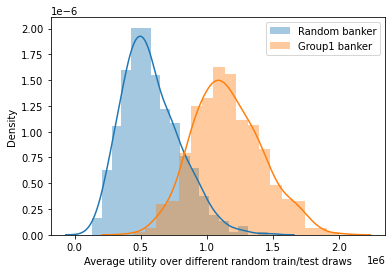

In [10]:
sns.distplot(results[0, :, :].flatten(), label="Random banker")
sns.distplot(results[1, :, :].flatten(), label="Group1 banker")
plt.legend()
plt.xlabel("Average utility over different random train/test draws")
plt.ylabel("Density")

## Results

Based on 100 repeats of 5-fold cv, our model using logistic regression is considerably better than the random model.

# Questions: reproducibility, reliability and privacy

### Is it possible to ensure that the policy maximises revenue?

We cannot ensure that the policy maximises revenue. This is due to the fact that the model is not perfect and we are maximising the expected utility. There is an uncertainty in the estimated probability of a new individual being credit-worthy. If there were no uncertainty in this and we knew in advance which of the new individuals were going to pay back, we could ensure that a policy would maximise revenue by only lending to the credit-worthy individuals.

### How can we take into account the uncertainty due to limited/biased data?

In an ideal world we would have an independent replication of our study and check whether or not new, independent data would develop the same type of policy that we obtained with the current data set. Another option is simulation of data in order to validate our policy based on constructed data (Dimitrakakis, 2020, pp. 35-36). When it comes to the current policy, there are several ways of taking this uncertainty into account when considering our objective of maximising expected utility.

### What are the consequences if the model is wrong?

There will always be a possibility that the model performs a lot worse in practice. For example our data set could be a bad representation of the population because of some change in the population properties after it was collected. Therefore it is important not to put too much trust into new models. Simple interpretable models have a clear advantage in this regard. If the model is simple enough you might spot errors before the model is tested in practice, and if you find a model to be wrong, it will be easier to understand why.

For the bank, one of the major consequences of the model being wrong is the loss of profit. If the model is granting credit too easily, the bank could incur losses due to the fact that they are granting credit and then loosing the entire investement $m$. If the model is too strict about granting credit, the bank is missing potential profit from the individuals that were declined credit, this would be $-m((1+r)^n - 1)$. The missed potential income could also cause the individuals that were wrongfully declined credit to apply for credit elsewhere. In that case, a hard-to-intepret model would also increase the difficulty in troubleshooting the reasons for the wrongfully decline of credit.

### How can we take into account the risk of the model being wrong?

It is possible to consider the two types of error the model can generate: 

1. classify new individuals as credit-worthy when they are in fact not ($a_{10}$)
2. classify new individuals as not being credit-worthy when they in fact are ($a_{01}$)

We can indicate the class of actual credit-worthy individuals as 'positive' ($a_{1}$) and the class of individuals not being credit-worthy as 'negatives' ($a_{0}$). Then our error (1) can be called a false positive and the other type of error (2) as a false negative. This corresponds to type 1 and type 2 erros, where the probability of type 1 errors is equivalent to the probability of false positive and type 2 error is equivalent to the probability of false negative. These probabilities can be estimated by looking at the fraction $\frac{a_{10}}{\# a_{1}}$. Similarily for the false negatives $\frac{a_{01}}{\# a_{0}}$. Adapted from (Azzalini & Scarpa, 2012, p. 139). For our example, if a new individual is classified as credit-worthy and this is a false positive, it implies the loss $-m$ (the lost investment). While if a new individual is classified as not being credit-worthy and this is a false negative, it implies the loss of $-m[(1+r)^{n} - 1]$ (the "lost" return on investment). 

The different actions are weighted by their reward values, so the decision maker grants credit based on the reward-weighted utility, not only whether or not the probability of repayment is above a threshold, such as $>0.5$. These weights are shown below:

|   |           |            | True              |         |
|---|-----------|------------|-------------------|---------|
|   |           |            | No default        | Default |
|   | Predicted | No default | $-m((1+r)^n - 1)$ | $-m$    |
|   |           | Default    | 0                 | 0       |


We could take into account the risk of the model being wrong by trying to control the type 1 error (false positive), we want to minimize false positives because this causes us to lose $-m$. We could enfore a higher threshold than 0 for the expected utility and then we could check this by demanding that the probability for type 1 errors (false positive) should be within an accepted range, e.g. maximum 5 %. We could attempt to find this threshold for type 1 erros by looking at the training data and check the probability for type 1 errors on a holdout set of the training data. Currently, we are attempting to control this by increasing the threshold for which to grant credit. When increasing the threshold for the expected utility, the model becomes more conservative. This would be equivalent to saying that we need to be for example $\ge$ 75 % sure that the loan is going to be repaid rather than just $\ge$ 50 % sure that the loan is going to be repaid in a situation where we only looked at the probability of repayment.

We would want to have the percentage of false positives to be below a limit, e.g. $max\_alpha = Pr(\text{false positive}) = 0.05$ 

An outline of the algorithm:

1. initialize $\epsilon = 0$, $alpha\_value = 1$ and $\Delta \epsilon = 1000$
2. while $alpha\_value \ge max\_alpha$:
    * false_positives = 0
    * predicted_actions = get_actions(validation_data, $\epsilon$)
    * false_positives += 
    * get_number_of_false_positives(predicted_actions, validation_data)
    * $alpha\_value$ = false_positives/len(validation_data)
    * $\epsilon = \epsilon + \Delta \epsilon$
3. alter policy so that $E(U(\cdot)) > \epsilon$ in order to grant credit to an individual 



### Does the existence of the database raise any privacy concerns?

The database is anonymized because there are no directly identifying attributes about the individuals (Dimitrakakis, 2020, p. 74). However, there is very specific information about the individuals in the database, such as age, personal status, sex and information about the employement situation of the individuals. There is also information about the housing and property situation of the different individuals.

There seems to be a high probability of inferring personal information about the individuals in the database by using for example record linkage. When considering differential privacy, it could be useful to assume that the adversary has potentially infinite side information (Dimitrakakis, 2020, p. 76). Where side information could be defined as information that an adversary has about all, except one observation of a dataset (A). We can call these datasets A and A’. The idea of differential privacy is then that even in the extreme case that the adversary has all this information, they should not be able to infer information about the missing observation based on differential private queries on A and A’ (Zhu, 2017, pp. 7-8). Unlimited access to this database could therefore be a large privacy concern. Both because adversaries could use side information to infer information from this database and/or because adversaries could use this database as side information to infer information from other databases. 

If we have the datasets A and A’ as above, an algorithm called ALG and define f(ALG(*)) as the probability distribution of the result. Then differential privacy could be defined as

$$
f(ALG(A)) < e^{\epsilon}f(ALG(A’)) + \delta
$$

where $\delta = 0$ for $\epsilon$-DP. The parameter $\epsilon$ here controls the degree of equality between the distributions, adapted from (Le Ny, 2020, pp. 5-6). Based on this definition it would seem that by decreasing $\epsilon$, the two distributions for the different algorithms would be more similar.

### How would secret database and public credit decisions affect privacy?

It would obviously be better to have the database secret instead of the database also being public. It could however be possible to infer a lot of information from the secret database by knowing the public credit decision. 

Because the bank is publishing the actual credit decisions, differential privacy is not possible. If, for example, an adversary with information about all but one attribute for a specific row, the adversary could infer the information of the missing attribute by using the public credit decisions. If the credit decisions were to be made public, the bank would have to consider the fact that adversaries could query the public “database” containing the credit decisions. This information could then be used as side information or together with additional side information to infer information about the individuals. 

One way to ensure privacy of the credit decision would be the “randomised response mechanism”. In this response mechanism, the true credit decision would be returned with probability p0 = 0.5 and with probability, p0’ = 1 – p0, the response mechanism would return 1 with probability 0.5 and 0 with probability 0.5. This calculation of the response could then be independent for each query (Dimitrakakis, 2020, p. 77). To ensure differential privacy for the public credit decisions, this algorithm could be implemented when potential adversaries queries the public “database”.

### How can we protect the data of the people in the training set?

We could use differential privacy to obscure the information in the public credit decisions that have been made by the bank.

* if the database is secret, but the credit decisions are public (we assume that the identities of the individuals also are public): we would have a randomised response mechanism for the credit decision. This randomised response mechanism will ensure that the public responses are correct with a probability $\le 1$ (Dimitrakakis, 2020, p. 77). This would make it harder to infer information about the individuals from the public information. Even if the database is not public, there is a risk of dishonest employees and/or digital attacks on the bank.

The training data contains several columns of attributes. We could implement a mechanism where each of the attributes would be transformed independently and then the entire observation (with all attributes) could be returned (Dimitrakakis, 2020, p. 82). For categorical columns of the training data, it would be possible to implement a randomised response mechanism as above. For the numerical values one could use a Laplace mechanism in order to transform the response by adding Laplace-distributed noise to the returned value. This could also be done by adding Laplace-distributed noise to each variable before computing a response, which would be a local privacy model (Dimitrakakis, 2020, p. 83). In order to protect the training data w.r.t. privacy the following outline of an algorithm could be implemented

1.	Add Laplace-noise to numerical attributes
2.	Add randomized response mechanism to categorical attributes

* if the database is public and the credit decisions are public: for categorical attributes, we could use a randomised response mechanism. For the numerical attributes, we can apply a Laplace mechanism in order to make the information differentially private. In this scenario as well, the bank is still vulnerable to dishonest employees and digital attacks as the original (true) data is still available inside the bank.

One could also have performed randomized response mechanism for the credit decision of the training data if this was the only data that would be public (and would have needed protection). In that case one would have a situation more similar to a centralized privacy model when adversaries query the data. Because one could for example calculate the true number of accepted credit applications and then add noise before returning the response (Dimitrakakis, 2020, p. 83). This would protect the data of the people in the training set because an adversary would lose the ability to infer information with the credit decision as side-information.

### How can we protect the data of the people that apply for loans?

We assume that the data for a new individual could potentially be leaked and considered non-secret. In that case we could apply the same techniques as for people in the training set. We would then apply a random mechanism to the input data for the new applicant. This could be done in the same manner as for the training data. There would be two possible scenarios:

1.	Protect the data by adding Laplace-noise to numerical attributes and using the randomized response mechanism for the categorical attributes
2.	Protect the data by adding noise to the response variable after the policy has made the decision on the true data of the new test data. This would be a type of centralized privacy model as mentioned above where the noise is added after the calculations

### Implement a private decision making mechanism for people that apply for new loans

We decided to implement local privacy with laplace noise for the quantitative attributes and randomized response mechanism for the categorical attributes. We then need to find values for the parameters of the noise. More specificly the scale $\lambda$ for the laplace noise and the probability of changing a value $p$ for the randomised response mechanism. From (Dimitrakakis 2020, p. 84) we have that for a function $f$ with sensitivity $\mathbb{L}(f)$:
$$
    \epsilon \ge \mathbb{L}(f)/\lambda
$$
Here the sensitivity is defined as $\mathbb{L}(f) \triangleq \sup_{xNx'} |f(x) - f(x')|$, and can be estimated by the range of the attribute.

From (Dimitrakakis 2020, p. 80) we have that for a randomized response mechanism with $p \le 1/2$:
$$
    \epsilon \ge \ln \left( \frac{1-p}{p} \right)
$$
With $k$ as the number of attributes, to achieve $\epsilon$-DP in total, each attribute needs to be $(\epsilon/k)$-DP (Dimitrakakis 2020, p. 82). Using this and the equations above, we can find the noise parameters as a function of the total privacy guarantee $\epsilon$:
$$
    \lambda = \frac{\mathbb{L}(f) k}{\epsilon}, \quad p = \frac{1}{e^{\epsilon/k} + 1}
$$

To simulate people applying for new loans, we split the data into training and test sets, and only apply the noise to the covariates in the test set. The utility is estimated by 5-fold CV for a more stable result. The implementation is listed in the apendix under the file privacy_guarantee.py

In [29]:
from privacy_guarantee import utility_epsilons
epsilon_sequence = np.linspace(1, 400, 200)
utility = utility_epsilons(epsilon_sequence)

Text(0, 0.5, 'Total utility')

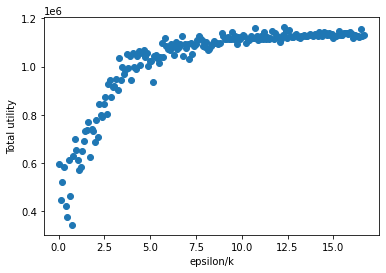

In [30]:
plt.scatter(epsilon_sequence/24, utility)
plt.xlabel("epsilon/k")
plt.ylabel("Total utility")

The plot above shows the cross validated total utility over different values of $\epsilon/k$. The number of attributes $k$ is 24, so to get the total privacy guarantee one would have to multiply by 24.

### Estimate the amount of loss in utility as we change the privacy guarantee

The amount of loss in utility is related to privacy. More privacy in general indicates less expected utility as more information is “lost” when the policy is deciding the best action. In order to estimate the loss in utility one can base the estimation of (alpha, beta) usefulness for an algorithm A, an algorithm with more privacy as A_hat and the (test) data set TD that is defined through Pr(|A(TD) – A_hat(TD)| <= alpha) > 1 – beta. A small difference between the algorithm and the privacy modified algorithm would imply a small loss in utility (Zhu, 2017, pp. 15-16). This would be one possible estimate of the loss in utility, while the absolute difference |U(TD) – U_hat(TD)| itself could be another estimate of loss in utility where U is the normal utility and U_hat is the utility with increased privacy.

### How will the interest rate affect the decision maker(s)?

The interest rate $r$ affects the action of the decision maker through the expected utility. The expected utility given that the credit application is granted, $a_{t}=1$ is defined as:

$$
E[U|a_{t} = 1] = -m \cdot Pr(r = r_{0}|a_{t} = 1) + m((1 + r)^{n} - 1) \cdot Pr(r = r_{1}|a_{t} = 1)
$$

This further implies that the interest rate only affects the reward where the debtor does not default. This reward defines the utility:

$$
m((1 + r)^{n} - 1)
$$

From this we see that increasing interest rate when investment $m$ and the number of periods $n \ge 1$ are held constant will monotonically increase the expected utility with increasing interest rate. For the decision maker this would mean that the probability for repayment of the credit: $Pr(r = r_{1}|a_{t} = 1)$ could be lower and the decision maker would still accept the credit application.

### How will the number of periods affect the decision maker(s)?

For the number of periods, the situation is the same as above, the expected utility will increase monotonically with increasing $n$ as long as $r > 0$. This is also logical because the bank would increase its profit with the number of interest rate accruals from the loan.

### What are two main ways to perturbate the data in order to protect the individuals of the data set?

There seems to be two possible mechanism to use in order to protect the individuals of the datasets. These are input perturbation and output perturbation. The input perturbation would add differently distributed types of noise to the columns of the data in order to protect the private information. Output perturbation would use “secret” data in the algorithm and then add noise to the output of that algorithm (Le Ny, 2020, pp. 18-22). These ways correspond to adding noise directly to the columns of the data sets before predicting the best action as an input perturbation. If we would calculate the best action based on the private data and then obtain our “true” credit decision we could add noise to this output we would have a mechanism closer to the output perturbation.

# Questions: fairness

In order to simplify notation, we define the following variables in the same manner as in (Dimitrakakis, 2020, pp. 103-104): 
* y: {1: the credit was repaid, 0: the credit was not repaid (default)}
* a: {1: the application was accepted, 0: the application was rejected}
* x: covariates
* z: sensitive covariates
* U(a, y): the decision maker’s utility function

## Guiding questions

### Identify sensitive variables

There are several variables in the data set that could potentially be considered sensitive. Variables such as the 9th covariate “Personal status and sex” could be considered sensitive. Because ceteris paribus we would ideally have that the chance of being offered credit should be the same whether the applicant is e.g. a married male or a single female. 
Covariate 11 “present residence since” could also be considered sensitive, since we generally do not want to discriminate w.r.t. this because we cannot determine the reason for the change of residency.

Covariate 13 “age” could also potentially be considered sensitive because, as with gender and personal status, we do not want to discriminate the credit decision upon age. Although we could argue that age must be considered when considering the credit decision w.r.t. repayment.

Covariate 20 “foreign worker” ceteris paribus could also be discussed to be a sensitive variable. Whether or not the worker is foreign or not should ideally not affect the credit decision.

### Do the original features already imply some bias in data collection?

We can think of bias in the data collection as either what covariates where selected to be measured (bias in selecting the columns of the training set) and as what type of individuals were selected to be measured (bias in selecting the rows of the training set). As the covariates seem to cover all the usefull information that one can collect within reason, we are not interested in looking at the bias in covariate selection. However when it comes to bias in the population sample, there are some problems that should be adressed. It is unclear who they chose to include in the data set. The response variable "repaid" implies that all the induviduals in the data set were given a loan, how else would they know wether they repiad or not. If the data only consists of people who were given a loan, then there are two posibilities for how the data was gathered:

1. They gave out loans as normal trying to maximise profit.
2. They gave out loans to everyone who applied for the sake of the experiment.

If point 2. is the case, then that is ideal. Most likely point 1. is the case and then this should be accounted for.
It is also worth pointing out that there are no single females in the data set. This could be because of the aforementioned bias. Maybe it was hard to get a loan as a single female when this data was collected.

### Analysis of decision function

It is important that the decision function does not discriminate against gender. To investigate how fair our model is with respect to gender, we plotted the amount of males/females that are classified as "did repay"/"didnot repay"


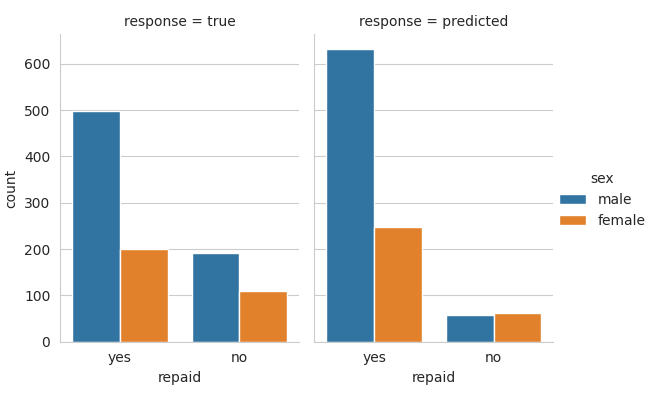

In [32]:
display(Image(filename="img/gender_compare.png", width = 500))


The first thing that is apparent in the plot is that our model overestimates how many that end up paying back. This is a problem, but it is not relevant to fairness.
What is relevant to fairness is the proportions of males/females that are predicted to repay. In the true data the proportions of men and women seems aproximately equal within those who repaied and those who did not. This sugests that gender should not be very relevant in predicting wether someone repayes. That is however not the case in our predicted response. Our model greatly favors males even though the true data tells us that it shouldn't.

### Fairness: balance of genders

When it comes to balance w.r.t. gender as a concept of fairness. We can look at balance as the concept: if we knew the true response ($y$), the policy would have been independent w.r.t. to the action ($a$) when considering the sensitive variable (Dimitrakakis, 2020, p. 104). In our case, that would mean that the policy should have similar distributions for women and for men given that we know whether or not the individual repaid ($y$). This also makes sense intuitively as a concept of fairness. If the loan actually was repaid and all the other covariates held equal, gender should not influence the action of the policy.

Formulated as an equation, this should approximately hold if the policy is balanced w.r.t. gender

$$
P^{\pi}(a|y, z = \text{male}) = P^{\pi}(a|y, z = \text{female})
$$

this should hold for y = 0/1 and z = male/female. Adapted from (Dimitrakakis, 2020, p. 105). In order to evaluate the fairness w.r.t. gender, we need to look at the output of the policy on the test set. Because our sensitive variable is gender and we want the action to be fair (independent on gender), we should separate the policy outcomes for the sensitive variables and then look at a and y based on this.


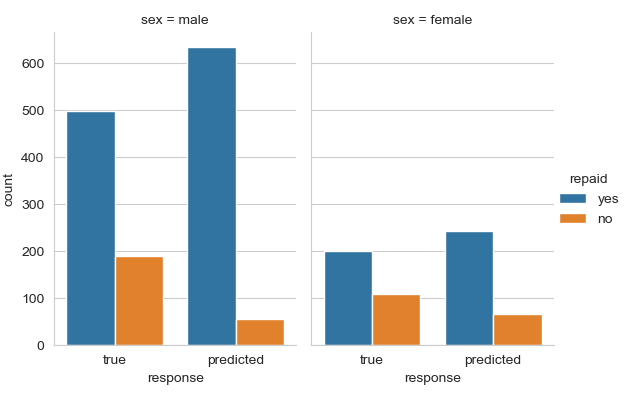

In [33]:
display(Image(filename="img/gender_balance.png", width = 500))


The histogram shows a graphical representation of the equation above that should hold approximately for balanced policies. The label 'predicted' in the histogram is equivalent to $a$ in the equation while 'true' corresponds to $y$. Note that this histogram has been created by using data from a random train/test split with test size = 0.25.

We can compare $P^{\pi}(a|y, z=\text{male})$ with $P^{\pi}(a|y, z=\text{female})$ by looking at the proportions of $a$ for different values of $y$ and $z$. Looking at these proportions we get:   

(a=1, a=0)

|                 | Male (z=1)        | Female (z=0)    |
|-----------------|-------------------|-----------------|
| No default (y=1)| (0.9286, 0.0714)  | (0.9, 0.1)      |
| Default (y=0)   | (0.8936, 0.1064)  | (0.6667, 0.3332)|

From the table, we can see that for the different genders, the proportion of $a=1$ was approximately equal when $y=1$, but for $y=0$ it seems like the proportion for $a=1$ is lower for women than for men.  

This would imply 

$$
P^{\pi}(a=1|y=0,z=\text{male}) > P^{\pi}(a=1|y=0, z=\text{female})
$$ 

That is, men has a higher probability of getting accepted for credit than women when we look at those who did not repay. This again would imply that the policy is not balanced based on the equation above because it does not (approximately) hold for $y=0$.
Consider relative frequency as a simplification of the probability distribution. The probability of event X can then be estimated with $\frac{n(X)}{n}$ where n is the total number of observation and $n(X)$ is the number of $X$ (Devore & Berk, 2012, p. 58). We can then look at the total variation distance which is defined as

$$
\frac{1}{2} \sum_{a \in A} |P(a|y, z=\text{male}) - P(a|y, z=\text{female})| 
$$

adapted from (Wikipedia, 2020). We can then use the estimated relative frequencies in the table above to estimate the total variation distance, we would then have the total variation distance for the “probability distribution” of the decisions $a$ that were made when the individuals repaid $y=1$

\begin{align*}
\frac{1}{2}(|P(a=0|y=1, z=\text{male}) - P(a=0|y=1, z=\text{female})|  \\ + |P(a=1|y=1, z=\text{male}) - P(a=1|y=1, z=\text{female})|)
\end{align*}

And the total variation distance when the individuals did not repay ($y=0$)

\begin{align*}
\frac{1}{2}(|P(a=0|y=0, z=\text{male}) - P(a=0|y=0, z=\text{female})| + \\ |P(a=1|y=0, z=\text{male}) - P(a=1|y=0, z=\text{female})|)
\end{align*}

thus looking at the estimated probability distribution of the decision $a$ in the cases $y=1$ and $y=0$.

From these approximations to the total variation distance, we see that the total variation distance for the case $y=1$ is relatively small compared to the case when $y=0$. From this, we can see that for outcome $y=0$, the total variation distance is greater than for the outcome $y=1$. This reflect the histogram above and states that the “distribution” among those who did not repay ($y=0$) has more variation between the genders than the “distribution” among those who did repay ($y=1$).


### What would happen if fairness also would consider the amount of loan requested?

We could look at fairness when taking the amount of loan requested into account by checking the sensitive variable $z$, which in our case is gender of the individual applying for a loan. We would like to check the fairness metric 

$$
F(\theta, \pi) = \sum_{y, z, a} (P_{\theta}^{\pi}(a|z, y) - P_{\theta}^{\pi}(a|y))^{2}
$$

Adapted from (Dimitrakakis, 2020, p. 107). We simplify and use relative frequency for the different measures of probability in the metric above. From the metric, the unfairness in balance is 0 when the two genders have equal probability of being accepted credit $a=1$ and being denied credit $a=0$ given the different values of the true response $y$. We see from the data that the median amount in the dataset was 2319.5, we therefore make a threshold for this value and check the fairness metric for amounts larger than this and lower than this. We use 10 repeated 5-fold cross validation in order to ensure stable values that do not depend to much on randomness in the data. We see that the 

$$
F(\theta, \pi) \approx 0.0699
$$

, while for amounts below the median, 

$$ 
F(\theta, \pi) \approx 0.0909
$$ 

and for amounts above the median 

$$ 
F(\theta, \pi) \approx 0.0969
$$ 

This implies that the degree of unfairness has increased when taking the amount requested into account when calculating fairness.

We also checked the gender ratios among the 10 % largest amounts when performing repeated cross validation. We then check the ratio of male/females being granted credit ($a=1$) among the largest amount of loans. This could give an indication of why there is more unfairness according to the metric above when it comes to the loans with the largest amounts. This is done by calculating the number of granted applications for males and females among the largest 10 % of the loan applications. This is calculated in the method ‘calculate_balance_ratios’. When averaging the results from a repeated cross validation, this returned '(male, female) ratio = 0.624, 0.257'. We see that this points toward men being overrepresented among the top 10 % of the applicants who did apply and was granted the largest loans. So the amount of loan seem to imply that men more often is granted the loans with the largest amounts.


### Stochastic gradient descent to find a policy that balances out fairness and utility

First, looking at “how much” the policy breaches the balance criterion can be defined as 
$$
F(\theta, \pi) = \sum_{a, y, z} |P_{\theta}^{\pi}(a|y, z) - P_{\theta}^{\pi}(a|y)|^{2}
$$
and then looking at the general utility $U(\theta, \pi) = P^{\pi}_{\theta}(y = a)$, that is, the distribution of correctly classified individuals given the $\theta$ and the policy $\pi$. The two are then combined in order to define the “value” of a policy 

$$
V(\lambda, \theta, \pi) = (1-\lambda)U(\theta, \pi) - \lambda F(\theta, \pi)
$$

This derivation is adapted from (Dimitrakakis, 2020, pp. 107-108). From the definition above, we see that this value requires $\theta$ and this is unknown.

We can then define the expected value of the policy
$$
V(\lambda, \xi, \pi) = \int [(1-\lambda)U(\theta, \pi) - \lambda F(\theta, \pi)] d\xi (\theta)
$$

Adapted from from. The subjective distribution $\xi$ could be estimated by a prior and a likelihood (Dimitrakakis, 2020, pp. 108-109). We see that this the integral that has to be solved over the different subjective beliefs in order to find the expected value of the policy $\pi$ for a specific $\lambda$.  

#### Finding the posterior distribution of $\theta$

First, we need to define the posterior distribution for $\theta$ so we can sample from it. Because we know that the values of the response $y \in \{0,1\}$, we see that if we define $p*=\frac{e^{\beta_{0} + \vec{\beta}^{T} \cdot \vec{x}}}{1 + e^{\beta_{0} + \vec{\beta}^{T} \cdot \vec{x}}}$, the probability for $y=1$ with the logistic regression, this corresponds to each $y$ being Bernoulli distributed. We also assume the $y$s are independent so that the likelihood is the product of the individual likelihoods. 
We also assume that the $y$s are independent which implies $p(y_{1}, … , y_{n}) = p(y_{1})…p(y_{n})$ (Devore & Berk, 2012, p. 354). This gives the likelihood function
$$
p(\vec{y} |\vec{\beta}) = \prod_{i=1}^{n} p*^{y_{i}}(1-p*)^{1-y_{i}}
$$
Which becomes
$$
log(p(\vec{y} |\vec{\beta})) = \sum_{i=1}^{n} y_{i}log(p*) + (1-y_{i})log(1-p*)
$$

In our case $\theta = \vec{\beta}$ because we are using a logistic regression as a model. We therefore use the Bayesian approach
$$
p(\vec{\beta}) \propto p(\vec{y} | \vec{\beta})p(\vec{\beta})
$$
adapted from (Gelman et al., 2014, p. 63). We assume that the priors are normally distributed to begin with, that is 

$$
\beta \sim N(\mu, \sigma^{2})
$$

This gives that the posterior joint distribution is
$$
p(\vec{\beta}) \propto p(\vec{\beta}) p(\vec{y} |\vec{\beta}) = \prod_{i=1}^{n} N(\mu_{i}, \sigma_{i}^{2}) p*^{y_{i}}(1-p*)^{1-y_{i}}
$$
We are then able to sample from the joint posterior distribution of $\theta$.

#### Policy $\pi$

The policy $\pi (a|x)$ can be parametrized as a softmax policy to give 
$$
\pi_{\beta} = \frac{e^{\beta^{T}x}}{1+ e^{\beta^{T}x}}
$$
Together with another form of the expected value of the policy, we can define that the following integral should be maximized w.r.t. $\pi_{\beta}$
$$
\int [(1-\lambda)E_{\theta}^{\pi_\beta}[U(\theta, \pi_{\beta}) - \lambda F(\theta, \pi_{\beta})] d\xi (\theta)
$$
Adapted from (Dimitrakakis et al., 2017). For $\theta$ values sampled from the $\xi$ distribution, we would like to maximize this expected utility for the policy. Because $\theta$ is present in the equation through $\pi_{\theta}$ we need the gradient of this policy. In general we could write
$$
\nabla_{\pi} V(\lambda, \xi, \pi) = \int [(1-\lambda) \nabla E_{\theta}^{\pi_\beta}[U(\theta, \pi_{\beta}) - \lambda \nabla F(\theta, \pi_{\beta})] d\xi (\theta)
$$
This can be maximized for a given $\lambda$ which is a parameter that balances the amount of utility versus the degree of fairness. We can also look at the gradient ascent for both the gained utility and the imbalance of fairness (cost). 
This can be summarized as 
$$
\sum_{x,y} \sum_{a} \pi_{\theta}(a|x) U(a, y) - \sum_{x,y} \sum_{a} \pi_{\theta}(a|x) F(\theta, \pi_{\beta})
$$

As the total quantity that we would like to maximize, given a $\lambda$ (Dimitrakakis, 2020, pp. 65). When taking the gradient of the different parts in the equation above, we can split it into the utility part and the “deviance from fairness” part.


#### Loss in fairness, $\nabla F(\theta, \pi)$
We then get
$$
\nabla \sum_{a, y, z} (P_{\theta}^{\pi} (a|y, z) - P_{\theta}^{\pi} (a|y, z’))^{2} \\
\sum_{a, y, z} \nabla (P_{\theta}^{\pi} (a|y, z) - P_{\theta}^{\pi} (a|y, z’))^{2} \\
\sum_{a, y, z} 2(P_{\theta}^{\pi} (a|y, z) - P_{\theta}^{\pi} (a|y, z’))(\nabla P - \nabla P’)
$$
We also use that 
$$
P_{\theta}^{\pi} = \sum_{x} P_{\theta} (y|a, x, z) P(x|a, z) \\
P_{\theta}^{\pi} = \sum_{x} P_{\theta} (y|a, x, z) \frac{P(a, x, z)}{P(a, z)} \\
P_{\theta}^{\pi} = \sum_{x} P_{\theta} (y|a, x, z) \frac{P(a|x, z)P(x, z)}{P(a|z)P(z)} \\
P_{\theta}^{\pi} = \sum_{x} P_{\theta} (y|a, x, z) \frac{P(a|x, z)P(x|z)P(z)}{P(a|z)P(z)} \\
P_{\theta}^{\pi} = \sum_{x} P_{\theta} (y|a, x, z) \frac{P(a|x, z)P(x|z)}{P(a|z)} \\
P_{\theta}^{\pi} = \sum_{x} P_{\theta} (y|a, x, z) P(x|z) \frac{\pi(a|x, z)}{\pi(a|z)} \\
$$
Adapted from (University of Oslo, 2020). And then looking at $\nabla F(\theta, \pi)$
$$
\nabla F(\theta, \pi) = \sum_{a, y, z} 2(P_{\theta}^{\pi} (a|y, z) - P_{\theta}^{\pi} (a|y, z’)) ( \sum_{x} P_{\theta} (y|a, x, z) P(x|z) \nabla \frac{\pi(a|x, z)}{\pi(a|z)} - \sum_{x} P’_{\theta} (y|a, x, z) P(x|z) \nabla \frac{\pi(a|x, z’)}{\pi(a|z’)})
$$

#### Gradient of utility, $\nabla U(\theta, \pi)$
For the utility, this can be expressed as a gradient of the utility of all observations, if we use the simplification
$$
U(\theta, \pi) = \sum_{x, y} \sum_{a} U(a, x, y) \pi_{\beta} (a|x)
$$
We then have
$$
\nabla U(\theta, \pi) = \sum_{x, y} \sum_{a} U(a, x, y) \nabla \pi_{\beta} (a|x)
$$
Adapted from (Dimitrakakis, 2020, p. 65). 


#### Gradient of policy
We see from the expressions above that we need the gradient of the policy in order to continue. We then look at the scenario where the data used in the model is regarded as a constant. We can then find the components of the gradient by normal partial derivatives of the policy w.r.t. the different $\beta$ variables. In general, we then get 

$$
\frac{\partial}{\partial \beta_{i}} \pi_{\beta} = \frac{x_{i} \cdot (e^{\beta^{T}x} + 1) - e^{\beta^{T}x} x_{i} e^{\beta^{T}x}}{(e^{\beta^{T}x} + 1)^{2}} \\
= \frac{ x_{i} e^{\beta^{T}x}}{(e^{\beta^{T}x} + 1)^{2}}
$$
The cross-entropy loss function can then be defined
$$
L = -(y log(\pi_{\beta}) + (1-y) log(1 - \pi_{\beta}))
$$
Adapted from (Hastie et al., 2016, p. 309). When using p* given the model trained on the existing data we want to use stochastic gradient descent to optimize policy $\pi_{\beta}$ for all the training observations by varying the $\beta$ value sin the policy. In order to minimize the loss $L$
$$
\frac{\partial L}{\partial \beta_{i}}  = -(\frac{y}{\pi_{\beta}} \cdot \frac{\partial \pi_{\beta}}{\partial \beta_{i}} – (1-y) \frac{1}{1 - \pi_{\beta}} \cdot \frac{\partial \pi_{\beta}}{\partial \beta_{i}}
$$
We could then, in theory use this loss together with the loss function and stochastic gradient descent in order to find a policy $\pi_{\beta}$ that maximizes the balanced value. As mentioned in (Dimitrakakis et al., 2017) this involves maximizing the value policy $\pi_{\beta}$ over the data using the integral shown above. When looking at the $\lambda$ we see that setting this to 0 would yield the integral over utility and we would ignore loss in fairness $F$. In that sense we would have to fix the $\lambda$ and then attempt to find the optimal policy $\pi$ that adheres to the given balance between utility and loss of fairness.

Note: we started implementing the stochastic gradient method in the 'stochastic_gradient' method within the file 'fairness_analysis' but did not manage to finish the implementation in time.


## Summarizing questions

## How can we measure whether our policy is fair?

Measuring fairness is a complex process when it comes to policies within machine learning. We could both look at calibration (probability distribution for outcome $y$ conditional on the action $a$ should be similar for all different values of the sensitive variable $z$) and balance (probability distribution for action $a$ should be similar conditional on outcome $y$ for all sensitive variables $z$). These measures both try to describe the fairness of the policy (Dimitrakakis, 2020, p. 105). Other ways to consider whether or not the policy is fair is by looking at confusion matrices that describe the false positive rates as discussed above.

We want to calculate a confusion matrix that describes the relations between the true 
responses and the predicted class (Hastie et al., 2016, p. 301). We use a random split with 0.25 as test size in order to generate the data in the confusion matrix for the different genders. We see that the rates are quite similar for $y=1$, 
but more dissimilar when it comes to $y=0$ (default). This is also shown through the graphical representation above.

male (z=1)

|                 | Action a=1        |  Action a=0     |
|-----------------|-------------------|-----------------|
| Response y=1    | 0.9206            | 0.0793          |
| Response y=0    | 0.8510            | 0.1489          |

female (z=0)

|                 | Action a=1        |  Action a=0     |
|-----------------|-------------------|-----------------|
| Response y=1    | 0.92              | 0.08            |
| Response y=0    | 0.6296            | 0.3703          |

Ideally, we would like to have approximate equality in the true confusion matrices of men ($z=1$) and women ($z=0$). This is an intuitive measure of fairness because we want the policy to grant credit applications ($a$) with equal rate when considering the individuals that actually repaid ($y$). There has also been discussed balance between classes as an expectation value of the predicted probability that the individual will repay (Garg et al., 2020). So, the ideal situation is equal rates in the confusion matrices, but in reality this is not always possible. The rates in the confusion matrices may also be the outcoume because of other conditions that are correlated with the sensitive variable $z$.


## How does the training data affect the fairness of the policy?

The training data affects the fairness of the policy through the fact that the model in the policy is fitted using the training data. The training data is also affected by the collection methods for the data. The model is then implicitly affecting the policy through the expected utility for the new observations that is considered for loans.
We can for example not say anything detailed about how the training data was collected, both methodology for collecting the data and selection of what data to collect. The data could be biased in the sense that the bank could be collecting data only about those observations they previously have provided a loan. If this is how the data was collected, this “prefiltering” of the data makes it biased towards the applicants that repays because the observations that the bank considered too high risk to accept the credit application have already removed from the training data. 

## Summarizing comments
The policy developed is as shown in the first part able to generate a higher expected utility than a random decision policy. The policy has also been modified in accordance with a local privacy model in order to increase privacy both for the training data and the test data. As was discussed in lecture 22.10.2020, the different ways of increasing the degree of privacy in the data depends on the future purpose of the data. For data that is to be published publicly, a local privacy model can make sense, but for data that is “protected” a more centralized approach to privacy can be applied. Applying privacy for example at the probability provided for $y=1$ by the model in the policy can be seen as protecting the data with regards to privacy while not distorting the data as much as a local privacy model (University of Oslo, 2020a). With regard to fairness, the balance between genders should in theory be improved if the approach with stochastic gradient descent from the last part of the report is performed. The current fairness w.r.t. balance could be seen to deviate, especially for the case when $y=0$, that is, the borrower defaulted. However, this aspect of fairness should improve after adjusting the policy with different SGD.

Further, the deficiencies with the conclusions in the report are addressed in the different sections. However, the bias in data collection could be highlighted as problematic. Also, the imbalance of the different categories could be seen as problematic. There are also latent hyperpriors that could be approximated in when making these decisions, especially macroeconomic conditions that would collectively affect all borrowers in the same manner as mentioned in the lecture (University of Oslo, 2020a). The assumption that the entire loan is to be repaid to a constant interest rate is also problematic. Firstly, the interest rate often varies and secondly, borrowers often transfer the loan to other banks. When it comes to methodology, more statistical analysis should ideally be performed in order to increase the accuracy of the prediction model, such as variable selection and/or model selection.


# References

Azzalini, A. & Scarpa, B. (2012). Data analysis and data mining: An introduction. Oxford: Oxford University Press.

Devore, J. & Berk, L. (2012). Modern Mathematical Statistics with Applications
(Springer Texts in Statistics). New York, NY: Springer New York.

Dimitrakakis, C. (2020). *Machine learning in science and society*. Unpublished. Department of Informatics, University of Oslo.

Dimitrakakis, C., Liu, Y., Parkes, D., & Radanovic, G. (2017). Bayesian fairness.

Garg, P., Villasenor, J., & Foggo, V. (2020). Fairness Metrics: A Comparative Analysis.

Gelman, A., Carlin, J., Stern, H., Dunson, D., Vehtari, A. & Rubin, D. (2014). Bayesian data analysis (3rd ed., Texts in statistical science). Boca Raton, Fl: CRC Press.

Hastie, T., Tibshirani, R. & Friedman, J. (2016). The Elements of Statistical Learning. Data Mining, Inference and Prediction. New York, NY: Springer New York.

Le Ny, J. (2020). Differential privacy for dynamic data (1st ed. 2020, SpringerBriefs in electrical and computer engineering). Cham, Switzerland: Springer.

University of Oslo. (2020). Tutlrial 2: Decisions, Utility and Fairness. Retrieved from https://www.uio.no/studier/emner/matnat/ifi/IN-STK5000/h20/forelesningsvideoer/2-tutorial-decisions-utility-fairness.mp4?vrtx=view-as-webpage 

University of Oslo. (2020a). Lecture videos. Retrieved from https://www.uio.no/studier/emner/matnat/ifi/IN-STK5000/h20/forelesningsvideoer/ 

Wikipedia. (2020, 12. august). Total variation distance of probability measures. Retrieved from https://en.wikipedia.orgwikiTotal_variation_distance_of_probability_measures 

Zhu, T. (2017). Differential privacy and applications (1st ed 2017 ed., Vol. 69, Advances in information security). Cham, Switzerland: Springer.


# Appendix

## group1_banker.py

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


class Group1Banker:

    def __init__(self):
        """A simple constructor that initializes the decision maker class with-
        out the utility epsilon.
        """
        self._utility_epsilon_enabled = False

    # Fit the model to the data.  You can use any model you like to do
    # the fit, however you should be able to predict all class
    # probabilities
    def fit(self, X, y):
        """Fits a logistic regression model.

        Args:
            X: The covariates of the data set.
            y: The response variable from the data set.
        """
        self.data = [X, y]

        self.model = self._fit_model(X, y)

        if self._utility_epsilon_enabled:
            self._utility_epsilon = self._calculate_utility_epsilon(
                max_alpha=self._max_type1_error)
        else:
            self._utility_epsilon = 0

    def _fit_model(self, X, y):
        """Fits the logistic model.

        Args:
            X: Covariates
            y: Response variable

        Notes:
            Using logistic regression, adapted from
            https://scikit-learn.org/stable/modules/generated/
                sklearn.linear_model.LogisticRegression.html
        """
        log_reg_object = LogisticRegression(random_state=1, max_iter=2000)
        return log_reg_object.fit(X, y)

    def enable_utility_epsilon(self, max_alpha=0.05):
        """Enables the utility epsilon in in order to reduce the probability of
        type 1 error.

        Args:
            max_alpha: the maximum 'allowed' probability for type 1 errors.
        """
        self._utility_epsilon_enabled = True
        self._max_type1_error = max_alpha

    def _calculate_utility_epsilon(self, max_alpha=0.05):
        """Estimates the threshold to use in the utility calculations based on
        the training data. The method does this by splitting the training data
        into a training set and a validation set. The validation set is used in
        order to estimate the tuning parameter 'epsilon' which implicitly
        calculates the estimated probability of type 1 error 'alpha_value' that
        should be below the threshold of 'max_alpha'.

        Args:
            max_alpha: the maximal probability for type 1 error that is allowed

        Returns:
            The estimated utility epsilon.
        """
        X = self.data[0]
        y = self.data[1]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, random_state=1, test_size=0.25)
        temp_model = self._fit_model(X_train, y_train)

        MAX_ITER = 100000
        count_iter = 0
        epsilon = 0
        delta_epsilon = 300

        # initial estimated alpha value
        alpha_value = 1

        while (alpha_value >= max_alpha) and count_iter < MAX_ITER:
            alpha_value = self._calculate_false_positive_rate(
                temp_model, X_test, y_test, epsilon)
            epsilon += delta_epsilon
            count_iter += 1

        return epsilon

    def _calculate_false_positive_rate(self, temp_model, X_test, y_test, eps):
        """Calculates the percentage of false positives among the results on
        the test set from the training data.

        Args:
            temp_model: the model fitted with the training part of the training
            data
            X_test: the covariates in the test part of the training data
            y_test: the test part in the test part of the training data
            eps: the epsilon (threshold) to use when deciding the best action
            of the policy
        """
        test_action = self._calculate_actions(temp_model, X_test, eps)

        false_positives = np.logical_and(y_test == 0, test_action == 1)

        return false_positives.mean()

    def _calculate_actions(self, model, X_test, eps=0):
        """Calculates the best action based on a specific epsilon (threshold).

        Args:
            model: the model to use when predicting the best action
            x_test: the test set to use when deciding the best action
            eps: the threshold to use when deciding the best action

        Returns:
            The best action dependent on the epsilon threshold.
        """
        p_c = model.predict_proba(X_test)

        r = self.rate
        # duration in months
        n = X_test['duration']
        # amount
        m = X_test['amount']

        e_X = p_c * m * ((1 + r) ** n - 1) + (1 - p_c) * (-m)

        if e_X > eps:
            return 1
        else:
            return 0

    # set the interest rate
    def set_interest_rate(self, rate):
        """Sets the interest rate for the decision maker.

        Args:
            rate: the interest rate to use in the calculations.
        """
        self.rate = rate
        return

    # Predict the probability of failure for a specific person with data x
    def predict_proba(self, X):
        """Predicts the probability for y=1 given new observations.

        Args:
            x: New, independent observations.

        Returns:
            The predicted probabilities for y=1.
        """
        return self.model.predict_proba(X)[:, 1]

    # The expected utility of granting the loan or not. Here there are two actions:
    # action = 0 do not grant the loan
    # action = 1 grant the loan
    #
    # Make sure that you extract the length_of_loan from the
    # 2nd attribute of x. Then the return if the loan is paid off to you is amount_of_loan*(1 + rate)^length_of_loan
    # The return if the loan is not paid off is -amount_of_loan.
    def expected_utility(self, X, action):
        """Calculate expected utility using the decision maker model.

        Args:
            X: New observations.
            action: Whether or not to grant the loan.

        Returns:
            The expected utilities of the decision maker.
        """
        if action == 0:
            return np.zeros(X.shape[0])

        r = self.rate
        p_c = self.predict_proba(X)

        # duration in months
        n = X['duration']
        # amount
        m = X['amount']

        e_x = p_c * m * ((1 + r) ** n - 1) + (1 - p_c) * (-m)
        return e_x

    def get_best_action(self, X):
        """Gets the best actions defined as the actions that maximizes utility.
        An epsilon for utility is also set as the threshold that the expected
        utility should exceed in order to get the best action. This utility
        epsilon is 0 if the banker is not configured to use this functionality.
        Otherwise it is estimated from the training data as the value that
        provide a type 1 error below the parameter '_max_type1_error'.

        Args:
            X: New observations.

        Returns:
            Best actions based on maximizing utility.
        """
        expected_utility_give_loan = self.expected_utility(X, 1)
        expected_utility_no_loan = self.expected_utility(X, 0)

        give_loan = expected_utility_give_loan > (
            expected_utility_no_loan + self._utility_epsilon)
        return give_loan


## TestImplementation.py

In [16]:
import random_banker
import group1_banker
import differential_privacy
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf


def get_raw_data():
    """ Reads in raw data then maps response to 0 and 1 and parses
    the categorical attributes to pandas.caategorical

    Returns:
        pandas DataFrame with the "raw" data
    """
    features = ['checking account balance', 'duration', 'credit history',
                'purpose', 'amount', 'savings', 'employment', 'installment',
                'marital status', 'other debtors', 'residence time',
                'property', 'age', 'other installments', 'housing', 'credits',
                'job', 'persons', 'phone', 'foreign', 'repaid']

    data_raw = pd.read_csv("../../data/credit/german.data",
                           delim_whitespace=True, names=features)

    # Mapping the response to 0 and 1
    data_raw.loc[:, "repaid"] = data_raw["repaid"].map({1: 1, 2: 0})

    categorical_columns = ['checking account balance', 'credit history',
                           'purpose', 'savings', 'employment', 'marital status',
                           'other debtors', 'property', 'other installments',
                           'housing', 'job', 'phone', 'foreign', 'repaid']
    data_raw.loc[:, categorical_columns] = data_raw[categorical_columns].apply(
        lambda x: x.astype('category'))

    return data_raw


def one_hot_encode(data):
    """ One hot encodes specified columns.

    Args:
        data: pandas DataFrame

    Returns:
        Pandas DataFrame with the categorical attributes one hot encoded
    """
    columns = ['checking account balance', 'credit history',
               'purpose', 'savings', 'employment', 'marital status',
               'other debtors', 'property', 'other installments',
               'housing', 'job', 'phone', 'foreign']
    dummies = pd.get_dummies(data[columns], drop_first=True)
    data = data.drop(columns, axis=1)

    return data.join(dummies)


def get_data():
    """ Gets the data and applies one hot encoding

    Returns:
        Pandas DataFrame with the usable data
    """
    data = get_raw_data()
    data = one_hot_encode(data)

    return data


def utility_from_obs(predicted_decision, true_decision, amount, duration, interest_rate):
    """Calculates utility for predicted decisions

    Args:
        predicted_decision: the model's best actions
        true_decision: if the observations repaid or not
        amount: the lending amounts
        duration: the number of periods
        interest_rate: the interest rate of the loan

    Returns:
        numpy array with the utilities for each decision.
    """
    utility = np.zeros_like(true_decision)

    predicted_decision_bool = predicted_decision == 1
    ind1 = np.logical_and(predicted_decision_bool, true_decision == 1)
    ind2 = np.logical_and(predicted_decision_bool, true_decision == 0)

    utility[ind1] = amount[ind1]*((1 + interest_rate)**duration[ind1] - 1)
    utility[ind2] = -amount[ind2]

    return utility


def utility_from_test_set(X, y, decision_maker, interest_rate):
    """Calculates total utility from a given test set.

    Args:
        X: the covariates of the test set
        y: the response variable of the test set
        decision_maker: the decision maker to use in order to calculate utility
        interest_rate: the interest rate to use when calculating utility

    Returns:
        The sum of utility from the test set and the sum of utility divided by
        total amount.
    """
    predicted_decision = decision_maker.get_best_action(X)

    amount = X['amount']
    duration = X['duration']

    utility = utility_from_obs(
        predicted_decision, y, amount, duration, interest_rate)

    return np.sum(utility), np.sum(utility)/np.sum(amount)


def repeated_cross_validation_utility(X, y, bankers, interest_rate, n_repeats=20, n_folds=5):
    """ Preforms repeated cross validation to find estimates for average utility
    for different bankers.

    Args:
        X: pandas data frame with covariates
        y: pandas series with the response
        bankers: iterable with bankers implementing the fit() and get_best_action() methods.
        interest_rate: float interest rate by month
        n_repeats: number of repeats in repeated cross validation
        n_folds: number of folds in k-fold cross validation

    Returns:
        numpy ndarray with shape (number of bankers, n_repeats, n_folds)
        containing the utilities
    """
    results = np.empty(shape=(len(bankers), n_repeats, n_folds))

    for i in range(n_repeats):

        kf = KFold(n_splits=n_folds, shuffle=True)
        j = 0
        for train_indices, test_indices in kf.split(X):
            X_train = X.iloc[train_indices, :]
            X_test = X.iloc[test_indices, :]
            y_train = y[train_indices]
            y_test = y[test_indices]

            for b, banker in enumerate(bankers):
                banker.fit(X_train, y_train)

                util, _ = utility_from_test_set(
                    X_test, y_test, banker, interest_rate)
                results[b, i, j] = util
            j += 1
    return results


def compare_with_random(n_repeats, n_folds, response, interest_rate):
    """ Tests the random banker against our group1 banker.

    Args:
        n_repeats: the number of repeated cv's
        n_folds: number of folds in k-fold cv
        response: the name of the response variable
        interest_rate: float interest rate by month

    Returns:
        numpy ndarray with shape (number of bankers, n_repeats, n_folds)
        containing the utilities
    """

    ## decision makers ##
    # random banker
    r_banker = random_banker.RandomBanker()
    r_banker.set_interest_rate(interest_rate)

    # group1 banker
    g_banker = group1_banker.Group1Banker()
    g_banker.set_interest_rate(interest_rate)

    # get data
    data = get_data()
    # pop removes and returns the given column, "response" is no longer in data
    y = data.pop(response)

    return repeated_cross_validation_utility(
        X=data, y=y,
        bankers=[r_banker, g_banker],
        interest_rate=interest_rate,
        n_repeats=n_repeats, n_folds=n_folds
    )


def compare_decision_makers(n_repeats, n_folds, response, interest_rate):
    """Tests the random banker against our group1 banker.

    Args:
        num_of_repeats: the number of tests to run
        response: the name of the response variable
        interest_rate: the interest rate to use when calculating utility
    """

    ## decision makers ##
    # random banker
    r_banker = random_banker.RandomBanker()
    r_banker.set_interest_rate(interest_rate)

    # group1 banker
    g_banker = group1_banker.Group1Banker()
    g_banker.set_interest_rate(interest_rate)

    # conservative group1 banker
    c_banker = group1_banker.Group1Banker()
    c_banker.enable_utility_epsilon(max_alpha=0.1)
    c_banker.set_interest_rate(interest_rate)

    # get data
    data = get_data()
    # pop removes and returns the given column, "response" is no longer in data
    y = data.pop(response)

    return repeated_cross_validation_utility(
        X=data, y=y,
        bankers=[r_banker, g_banker, c_banker],
        interest_rate=interest_rate,
        n_repeats=n_repeats, n_folds=n_folds
    )


def _get_priors(model):
    """Genereates a normally distributed prior for each of the regression
    coefficients with mean = the estimated regression coefficients.

    Args:
        model: the logistic regression model
    Returns:
        The priors
    """
    priors = tfp.distributions.Normal(
        loc=[[i for i in model.coef_[0]]], scale=1)

    return priors


def _get_likelihood(model, X, y_values):
    """Gets the log-likelihood for the data given the model.

    Args:
        model: the probability model used
        X: the covariates
        y_values: the response values
    Returns:
        The log-likelihood
    """
    log_probs = model.predict_log_proba(X)[:, 0]
    log_lik = 0

    for i in range(len(y_values)):
        log_lik += y_values[i]*log_probs[i] + (1-y_values[i])*(1-log_probs[i])

    return log_lik


## differential_privacy.py

In [17]:
""" Module for making data diferrentially private

# TODO: Figure out what to do with discrete numerical attributes
    Round them off after adding noise?
"""

import numpy as np
import numpy.random as rnd


def transform_categorical(data, p):
    """ Transform a column of categorical data data with a randomised response mechanism

    Args:
        data: Array with data from a categorical attribute.
        p: The probablity of changing a datapoint.

    Returns:
        Array of the same length as the input data, containing the transformed data.
    """
    transform_indexing = rnd.choice([True, False], size=data.size, p=[p, 1-p])
    new_values = rnd.choice(np.unique(data), size=transform_indexing.sum())
    new_data = data.copy()
    new_data.loc[transform_indexing] = new_values
    return new_data


def transform_quantitative(data, b, scale_noise=False):
    """ Transform a column of quantitative data with laplace noise

    Args:
        data: Array with the data from a quantitative attribute.
        b: Positive float used as the second parameter of the laplace distribution,
            referred to as the scale or the diversity of the distribution.
        scale_noise: If true, scale the laplace noise by the standard deviation of the data.
            This allows the same value for b to be used on differently scaled data

    Returns:
        Array of the same length as the input data, containing the transformed data.
    """
    noise = rnd.laplace(0, b, size=data.size)
    if scale_noise:
        noise *= data.std()
    return data + noise


def apply_random_mechanism_to_data(data_frame, quantitative_names, categorical_names, laplace_delta, p):
    """ Aplies a random mechanism to certain columns of a data frame

    Args:
        data_frame: A pandas data frame
        quantitative_names: An iterable with the column names of the quantitative attributes
            you wish to add laplace noise to.
        categorical_names: An iterable with the column names of the categorical attributes you
            wish to transform.
        laplace_delta: The delta parameter to supply to the laplace noise
        p: The probability to suppøy to the random noise for categorical data.

    Returns:
        Pandas data frame of the same dimentions as the one supplied, but with differentially private data.
    """
    dp_data = data_frame.copy()

    for column_name in quantitative_names:
        dp_data[column_name] = transform_quantitative(
            data_frame[column_name], b=laplace_delta, scale_noise=True)

    for column_name in categorical_names:
        dp_data[column_name] = transform_categorical(
            data_frame[column_name], p)

    return dp_data

## privacy_guarantee.py

In [18]:
import TestImplementation
import group1_banker
import differential_privacy
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def apply_epsilon_DP_noise(data, epsilon):
    """ Applies noise to data to make it epsilon-DP

    Args:
        data: pandas DataFrame containing all the data
        epsilon: float value for epsilon

    Returns:
        pandas DataFrame with epsilon-DP version of data
    """
    dp_data = data.copy()
    numeric_variables = [
        'duration', 'age', 'residence time', 'installment',
        'amount', 'persons', 'credits'
    ]
    n_columns = len(dp_data.columns)
    col_epsilon = epsilon/n_columns

    for column in dp_data:
        if column in numeric_variables:
            val_range = dp_data[column].max() - dp_data[column].min()
            laplace_lambda = val_range/col_epsilon
            dp_data.loc[:, column] = differential_privacy.transform_quantitative(
                data=dp_data[column], b=laplace_lambda
            )
        else:
            rrm_p = 1/(np.exp(col_epsilon) + 1)
            dp_data.loc[:, column] = differential_privacy.transform_categorical(
                data=dp_data[column], p=rrm_p
            )

    return dp_data


def utility_epsilons(epsilon_sequence, verbose=False):
    """ Finds total utility of the group1_banker with epsilon-DF data for different values of epsilon
    with 5-fold cv.

    Args:
        epsilon_sequence: iterable with the values for epsilon
        verbose: If True tells you when it starts on a new fold.
            Defaults to False.

    Returns:
        np array with the utility values averaged over the cv folds
    """
    banker = group1_banker.Group1Banker()
    banker.set_interest_rate(0.05)

    data = TestImplementation.get_raw_data()

    utilities = np.zeros_like(epsilon_sequence)
    n_folds = 5
    kf = KFold(n_splits=n_folds)
    i_fold = 0
    for train, test in kf.split(data):
        if verbose:
            i_fold += 1
            print(f"Started on fold {i_fold}/{n_folds}")

        X_train = data.iloc[train, :]
        X_train = TestImplementation.one_hot_encode(X_train)
        y_train = X_train.pop('repaid')

        for i, epsilon in enumerate(epsilon_sequence):
            X_test = data.iloc[test, :]
            y_test = X_test.pop('repaid').to_numpy()

            # We need to use original amount and durantions for calculating utility
            amount = X_test["amount"]
            duration = X_test["duration"]

            X_test = apply_epsilon_DP_noise(X_test, epsilon)
            X_test = TestImplementation.one_hot_encode(X_test)

            banker.fit(X_train, y_train)
            pred_decision = banker.get_best_action(X_test)
            utility = TestImplementation.utility_from_obs(
                pred_decision, y_test, amount, duration, 0.05)
            utilities[i] += np.sum(utility)/n_folds

    return utilities

## fairness_analysis.py

In [19]:
import TestImplementation
import group1_banker
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import tensorflow as tf


def total_variation(prob1, prob2):
    """Calculates the total variation distance by using the formula from
    Wikipedia as referenced in the exercise text.

    Args:
        prob1: probability for a=1 for male (z=1)
        prob2: probability for a=1 for female (z=0)

    """
    return (1/2)*np.sum(np.abs(prob1 - prob2))


def fairness(response, interest_rate=0.05):
    """Calculates proportion of a=1 conditional on gender (z) and response (y).

    Args:
        response: name of response variable in the data set
        interest_rate: the interest rate to use
    """
    data = TestImplementation.get_data()
    y = data.pop(response)
    X = data

    g_banker = group1_banker.Group1Banker()
    g_banker.set_interest_rate(interest_rate)

    fairness_results = repeated_cv_fairness(
        X, y, g_banker, n_repeats=10, n_folds=5)

    print(f"TVD y=1 = {np.mean(fairness_results['tv1'])}")
    print(f"TVD y=0 = {np.mean(fairness_results['tv0'])}")

    print(f"F_balance = {np.mean(fairness_results['fair_balance'])}")
    print(f"F_balance low = {np.mean(fairness_results['fair_low'])}")
    print(f"F_balance high = {np.mean(fairness_results['fair_high'])}")
    print(
        f"(male, female) ratio = {np.mean(fairness_results['gender_balance'], axis = 0)}")


def _get_gender(obs):
    """Gets gender from observation, 1 = male and 0 = female.

    Args:
        obs: covariates from a single observation

    Returns:
        1 if male, 0 if female.
    """
    if obs['marital status_A92'] == 1:
        return 0
    else:
        return 1


def calculate_balance_ratios(df):
    """Calculates the ratios between the actions dependent on the amounts. Will
    check the ratio of loan  among the top 10 % of the amounts.
    Args:
        df: dataframe containing information about a, y, z and amount of loan
            requested
    Returns:
        The gender ratios
    """
    top10 = np.sort(df['am'])[-int(0.1*len(df))]
    df = df[df['am'] >= top10]

    male_ratio = len(df[(df['a'] == 1) & (df['z'] == 1)])/len(df)
    female_ratio = len(df[(df['a'] == 1) & (df['z'] == 0)])/len(df)
    return (male_ratio, female_ratio)


def repeated_cv_fairness(X, y, banker, n_repeats=10, n_folds=10):
    """Calculates various fairness metrics with a repeated k-fold cross
    validation.

    Args:
        X: covariates
        y: response variable
        n_repeats: repetitions of k-fold CV
        n_folds: number of folds to use in CV

    Returns:
        A dictionary of the fairness results.
    """
    amount_threshold = np.median(X['amount'])

    fairness_results = {}
    total_var_dists_y1 = np.zeros(n_repeats*n_folds)
    total_var_dists_y0 = np.zeros(n_repeats*n_folds)
    total_fairness_bal = np.zeros(n_repeats*n_folds)
    total_fairness_bal_low = np.zeros(n_repeats*n_folds)
    total_fairness_bal_high = np.zeros(n_repeats*n_folds)
    gender_balance = np.zeros(shape=(n_repeats*n_folds, 2))
    t = 0

    for i in range(n_repeats):
        kf = KFold(n_splits=n_folds, shuffle=True)
        for train_indices, test_indices in kf.split(X):
            X_train = X.iloc[train_indices, :]
            X_test = X.iloc[test_indices, :]
            y_train = y[train_indices]
            y_test = y[test_indices]

            # fit model
            banker.fit(X_train, y_train)

            num_obs = len(X_test)
            a_obs = np.zeros(num_obs)
            am_obs = np.zeros(num_obs)
            y_obs = np.zeros(num_obs)
            z_obs = np.zeros(num_obs)

            a_obs = banker.get_best_action(X_test)

            for new_obs in range(num_obs):
                obs = X_test.iloc[new_obs]

                z_i = _get_gender(obs)
                y_i = y_test.iloc[new_obs]
                am_i = X.iloc[new_obs]['amount']

                y_obs[new_obs] = y_i
                z_obs[new_obs] = z_i
                am_obs[new_obs] = am_i

            fairness_df = pd.DataFrame(
                {'z': list(z_obs), 'a': list(a_obs), 'y': list(y_obs), 'am': list(am_obs)})

            men = fairness_df.loc[fairness_df['z'] == 1]
            women = fairness_df.loc[fairness_df['z'] == 0]

            z1_y1_a1 = len(men[(men['y'] == 1) & (
                men['a'] == 1)])/len(men[men['y'] == 1])
            z1_y0_a1 = len(men[(men['y'] == 0) & (
                men['a'] == 1)]) / len(men[men['y'] == 0])
            z0_y1_a1 = len(women[(women['y'] == 1) & (
                women['a'] == 1)])/len(women[women['y'] == 1])
            z0_y0_a1 = len(women[(women['y'] == 0) & (
                women['a'] == 1)])/len(women[women['y'] == 0])

            prob_m_y1 = np.array([z1_y1_a1, 1-z1_y1_a1])
            prob_w_y1 = np.array([z0_y1_a1, 1-z0_y1_a1])

            prob_m_y0 = np.array([z1_y0_a1, 1-z1_y0_a1])
            prob_w_y0 = np.array([z0_y0_a1, 1-z0_y0_a1])

            total_var_dists_y1[t] = total_variation(prob_m_y1, prob_w_y1)
            total_var_dists_y0[t] = total_variation(prob_m_y0, prob_w_y0)

            total_fairness_bal[t] = _calculate_balance(fairness_df)
            total_fairness_bal_low[t] = _calculate_balance(
                fairness_df, threshold=amount_threshold, upper=False)
            total_fairness_bal_high[t] = _calculate_balance(
                fairness_df, threshold=amount_threshold, upper=True)
            gender_balance[t] = calculate_balance_ratios(fairness_df)
            t = t + 1

    fairness_results['tv0'] = total_var_dists_y0
    fairness_results['tv1'] = total_var_dists_y1
    fairness_results['fair_balance'] = total_fairness_bal
    fairness_results['fair_low'] = total_fairness_bal_low
    fairness_results['fair_high'] = total_fairness_bal_high
    fairness_results['gender_balance'] = gender_balance

    return fairness_results


def _calculate_balance(df, threshold=None, upper=True):
    """Calculates the probability for the balance metric using relative
    frequency.

    Args:
        df: dataframe containing
            a: the action taken by the algorithm
            y: the true response
            z: the gender of the observation
            am: the amount of loan
        threshold: whether or not to threshold the amount
        upper: use upper part of threshold

    Returns:
        Calculated balance loss.
    """
    if (threshold == None):
        N = len(df)
        bal = 0
        for a in range(0, 2):
            for y in range(0, 2):
                p_y = len(df[df['y'] == y])/N
                p_a_and_y = len(df[(df['a'] == a) & (df['y'] == y)])/N
                p_a_y = p_a_and_y/p_y
                for z in range(0, 2):
                    p_y_z = len(df[(df['y'] == y) & (df['z'] == z)])/N
                    p_a_and_y_and_z = len(
                        df[(df['a'] == a) & (df['y'] == y) & (df['z'] == z)])/N
                    p_a_y_z = p_a_and_y_and_z/p_y_z
                    bal += (p_a_y_z - p_a_y)**2

        return bal
    elif upper:
        N = len(df['am'] > threshold)
        bal = 0
        for a in range(0, 2):
            for y in range(0, 2):
                p_y = len(df[(df['y'] == y) & (df['am'] > threshold)])/N
                p_a_and_y = len(df[(df['a'] == a) & (
                    df['y'] == y) & (df['am'] > threshold)])/N
                p_a_y = p_a_and_y/p_y
                for z in range(0, 2):
                    p_y_z = len(df[(df['y'] == y) & (
                        df['z'] == z) & (df['am'] > threshold)])/N
                    p_a_and_y_and_z = len(
                        df[(df['a'] == a) & (df['y'] == y) & (df['z'] == z) & (df['am'] > threshold)])/N
                    p_a_y_z = p_a_and_y_and_z/p_y_z
                    bal += (p_a_y_z - p_a_y)**2
        return bal
    else:
        N = len(df['am'] <= threshold)
        bal = 0
        for a in range(0, 2):
            for y in range(0, 2):
                p_y = len(df[(df['y'] == y) & (df['am'] <= threshold)])/N
                p_a_and_y = len(df[(df['a'] == a) & (
                    df['y'] == y) & (df['am'] <= threshold)])/N
                p_a_y = p_a_and_y/p_y
                for z in range(0, 2):
                    p_y_z = len(df[(df['y'] == y) & (df['z'] == z)
                                   & (df['am'] <= threshold)])/N
                    p_a_and_y_and_z = len(
                        df[(df['a'] == a) & (df['y'] == y) & (df['z'] == z) & (df['am'] <= threshold)])/N
                    p_a_y_z = p_a_and_y_and_z/p_y_z
                    bal += (p_a_y_z - p_a_y)**2
        return bal


def countplot():
    """ Create count plot to visualize gender fairness
    """
    # Get data
    X = TestImplementation.get_data()
    y = X.pop("repaid")

    # Fit the banker
    banker = group1_banker.Group1Banker()
    banker.set_interest_rate(.05)
    banker.fit(X, y)

    # Get predictions
    y_predicted = banker.get_best_action(X)
    print(y_predicted.shape)

    is_female = X["marital status_A92"] == 1
    sex = pd.Series(is_female.map({True: "female", False: "male"}))

    gender_data = pd.DataFrame()
    gender_data["repaid"] = pd.concat((y, pd.Series(y_predicted))).map(
        {0: "no", 1: "yes"})
    gender_data["response"] = np.repeat(["true", "predicted"], y.size)
    gender_data["sex"] = pd.concat((sex, sex))

    sns.set_style(style="whitegrid")
    g = sns.catplot(x="repaid", hue="sex", col="response",
                    data=gender_data, kind="count",
                    height=4, aspect=.7)
    plt.savefig("img/gender_compare.png")
    plt.show()


def check_gender_significance():
    """ Uses statsmodels to find statistics for the logistic model.
    """
    import statsmodels.api as sm

    X = TestImplementation.get_data()
    y = X.pop("repaid")

    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    print(result.summary2())


def confusion_matrix(response="repaid", interest_rate=0.05):
    """Calculates the confusion matrix for males/females.
    Args:
        response: response in dataset
        interest_rate: the interest rate to use
    """
    data = TestImplementation.get_data()
    y = data.pop(response)
    X = data

    g_banker = group1_banker.Group1Banker()
    g_banker.set_interest_rate(interest_rate)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=1, test_size=0.25)

    g_banker.fit(X_train, y_train)

    num_obs = len(X_test)
    a = g_banker.get_best_action(X_test)
    y = np.zeros(num_obs)
    z = np.zeros(num_obs)

    for new_obs in range(num_obs):
        obs = X_test.iloc[new_obs]
        z_i = _get_gender(obs)
        y_i = y_test.iloc[new_obs]

        y[new_obs] = y_i
        z[new_obs] = z_i

    fairness_df = pd.DataFrame({'z': list(z), 'a': list(a), 'y': list(y)})
    men = fairness_df.loc[fairness_df['z'] == 1]
    women = fairness_df.loc[fairness_df['z'] == 0]

    tp_male = len(men[(men['a'] == 1) & (men['y'] == 1)]) / \
        len(men[men['y'] == 1])
    fp_male = len(men[(men['a'] == 1) & (men['y'] == 0)]) / \
        len(men[men['y'] == 0])
    tn_male = len(men[(men['a'] == 0) & (men['y'] == 0)]) / \
        len(men[men['y'] == 0])
    fn_male = len(men[(men['a'] == 0) & (men['y'] == 1)]) / \
        len(men[men['y'] == 1])

    print(tp_male, fp_male, tn_male, fn_male)

    tp_female = len(women[(women['a'] == 1) & (women['y'] == 1)]) / \
        len(women[women['y'] == 1])
    fp_female = len(women[(women['a'] == 1) & (women['y'] == 0)]) / \
        len(women[women['y'] == 0])
    tn_female = len(women[(women['a'] == 0) & (women['y'] == 0)]) / \
        len(women[women['y'] == 0])
    fn_female = len(women[(women['a'] == 0) & (women['y'] == 1)]) / \
        len(women[women['y'] == 1])

    print(tp_female, fp_female, tn_female, fn_female)


def utility(a, y, pi):
    """Calculates the identity utility function.
    Args:
        a: the action taken by the policy
        y: the true response
        pi: the probability for action
    """
    util = 0
    for y_i in range(len(y)):
        for a_i in range(len(a)):
            util += pi*1 + (1-pi)*0
    return util


def stochastic_gradient():
    """Start of stochastic gradient descent for maximizing method.
    """
    data = TestImplementation.get_data()
    y = data.pop(response)
    X = data

    sgd_opt = tf.optimizers.SGD(learning_rate=0.2)

    betas = tf.Variable(np.zeros(len(X.iloc[0])))

    x = X.iloc[1].to_numpy()

    with tf.GradientTape() as tape:
        pi = tf.math.exp(tf.transpose(betas)*x) / \
            (tf.math.exp(tf.transpose(betas)*x) + 1)


if __name__ == "__main__":
    # countplot()
    check_gender_significance()
    np.random.seed(1)
    response = 'repaid'
    fairness(response)
    confusion_matrix()


Optimization terminated successfully.
         Current function value: 0.447977
         Iterations 7
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.267     
Dependent Variable:      repaid              AIC:                 991.9540  
Date:                    2020-10-23 13:01    BIC:                 1227.5263 
No. Observations:        1000                Log-Likelihood:      -447.98   
Df Model:                47                  LL-Null:             -610.86   
Df Residuals:            952                 LLR p-value:         2.2973e-43
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          7.0000                                             
----------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
durat

## random_banker.py

In [20]:
import numpy as np


class RandomBanker:

    # Fit the model to the data.  You can use any model you like to do
    # the fit, however you should be able to predict all class
    # probabilities
    def fit(self, X, y):
        self.data = [X, y]

    # set the interest rate
    def set_interest_rate(self, rate):
        self.rate = rate
        return

    # Predict the probability of failure for a specific person with data x
    def predict_proba(self, x):
        return 0

    # THe expected utility of granting the loan or not. Here there are two actions:
    # action = 0 do not grant the loan
    # action = 1 grant the loan
    #
    # Make sure that you extract the length_of_loan from the
    # 2nd attribute of x. Then the return if the loan is paid off to you is amount_of_loan*(1 + rate)^length_of_loan - amount_of_loan
    # The return if the loan is not paid off is -amount_of_loan.
    def expected_utility(self, x, action):
        print("Expected utility: Not implemented")
    # Return the best action. This is normally the one that maximises expected utility.
    # However, you are allowed to deviate from this if you can justify the reason.

    def get_best_action(self, x):
        return np.random.choice(2, x.shape[0])
